In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from tqdm import tqdm

from isingCA_global_xi import isingCA

C:\Users\Heysoos\anaconda3\envs\torchstuff\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# resolution of grid
RESX=128
RESY=128
RES = (RESX, RESY)

CHANNELS=1 # number of channels in grid
RADIUS=1
BETA=1/(RADIUS * RADIUS * CHANNELS)
ca = isingCA(RES, CHANNELS=CHANNELS, BETA=BETA, RADIUS=RADIUS).cuda()

In [3]:
temps = np.linspace(1.53, 3.28, 88)
eq_steps = 2048
timesteps = 2048

# stats to save
save_every = 5
all_obvs = []
Cs = []

state, obvs = ca.initGrid()

Tc = 2.2691
for temp in tqdm(temps):
    state, obvs = ca.initGrid()
    # if temp < Tc:
    #     state[0, 0] = (torch.rand_like(state[0, 0]) > (0.5 * temp/Tc)) * 2. - 1.
    state[0, -1] = torch.ones_like(state[0, -1]) * (1./temp)

    # equilibrate for a bit
    for t in range(eq_steps):
        state, obvs = ca.forward(state)

    all_obvs_t = []
    for t in range(timesteps):
        state, obvs = ca.forward(state)

        if t % save_every == 0:
            all_obvs_t.append(obvs.cpu().numpy())

    all_obvs_t = np.stack(all_obvs_t)

    e_t = all_obvs_t[:, 0]
    e2_t = all_obvs_t[:, 1]
    m_t = all_obvs_t[:, 2]
    m2_t = all_obvs_t[:, 3]


    E_t = np.mean(e_t)
    M_t = np.mean(m_t)
    C_t = (np.mean(e2_t) - np.mean(e_t) ** 2) * (1./temp) ** 2
    X_t = (np.mean(m2_t) - np.mean(m_t) ** 2) * (1./temp)

    all_obvs.append(np.stack([E_t, M_t, C_t, X_t]))

100%|██████████| 88/88 [02:47<00:00,  1.91s/it]


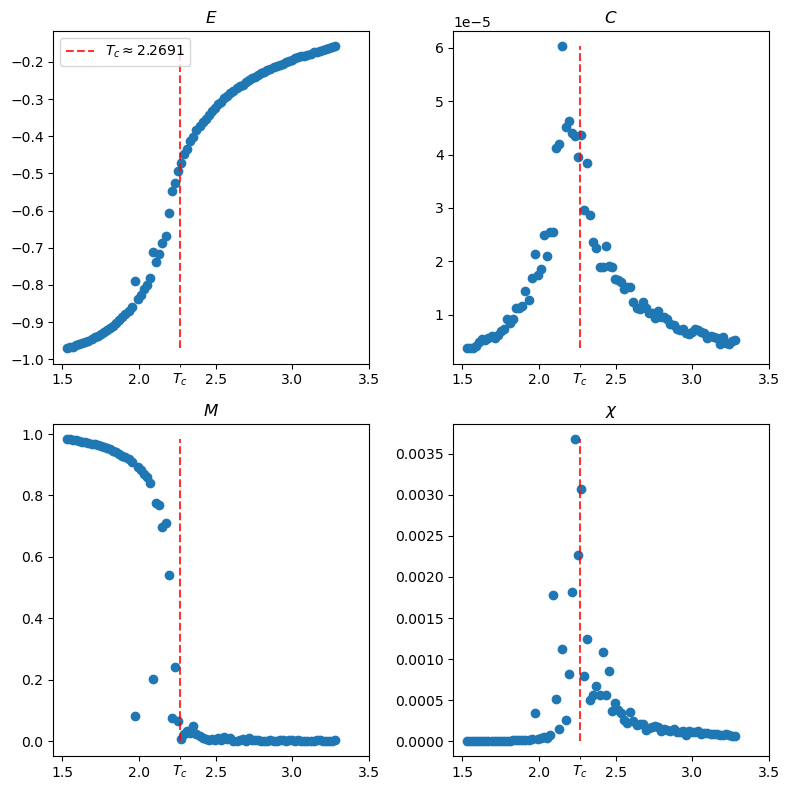

In [61]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

E = [obv[0] for obv in all_obvs]
M = [obv[1] for obv in all_obvs]
C = [obv[2] for obv in all_obvs]
X = [obv[3] for obv in all_obvs]

marker = 'o'
axes[0, 0].plot(temps, E, marker)
axes[1, 0].plot(temps, np.abs(M), marker)
axes[0, 1].plot(temps, C, marker)
axes[1, 1].plot(temps, X, marker)


axes[0, 0].set_title(r'$E$')
axes[1, 0].set_title(r'$M$')
axes[0, 1].set_title(r'$C$')
axes[1, 1].set_title(r'$\chi$')

data = [E, C, np.abs(M), X]
for i, ax in enumerate(axes.flatten()):
    ax.vlines(Tc, np.min(data[i]), np.max(data[i]), 'r', '--', alpha=0.8, label=rf'$T_c \approx {Tc:.4f}$')
    ax.set_xticks(list(ax.get_xticks())[1:] + [Tc], minor=True, labels=list(ax.get_xticklabels())[1:] + [r'$T_c$'])
axes[0, 0].legend()


# axes[0, 1].set_ylim([0, 1e-3])
# axes[1, 1].set_ylim([0, 1])
plt.tight_layout()
plt.savefig('ising_stats.png', bbox_inches='tight')

### Again for different size networks

In [62]:
sizes = [2 ** i for i in range(4, 11)]
temps = np.linspace(1.53, 3.28, 88)
eq_steps = 512
timesteps = 512

# stats to save
save_every = 5
all_obvs = []
Cs = []


for size in sizes:
    RES = (size, size)
    ca = isingCA(RES, CHANNELS=CHANNELS, BETA=BETA, RADIUS=RADIUS).cuda()

    state, obvs = ca.initGrid()

    all_obvs_N = []
    for temp in tqdm(temps):
        state, obvs = ca.initGrid()
        # if temp < Tc:
        #     state[0, 0] = (torch.rand_like(state[0, 0]) > (0.5 * temp/Tc)) * 2. - 1.
        state[0, -1] = torch.ones_like(state[0, -1]) * (1./temp)

        # equilibrate for a bit
        for t in range(eq_steps):
            state, obvs = ca.forward(state)

        all_obvs_t = []
        for t in range(timesteps):
            state, obvs = ca.forward(state)

            if t % save_every == 0:
                all_obvs_t.append(obvs.cpu().numpy())

        all_obvs_t = np.stack(all_obvs_t)

        e_t = all_obvs_t[:, 0]
        e2_t = all_obvs_t[:, 1]
        m_t = all_obvs_t[:, 2]
        m2_t = all_obvs_t[:, 3]


        E_t = np.mean(e_t)
        M_t = np.mean(m_t)
        C_t = (np.mean(e2_t) - np.mean(e_t) ** 2) * (1./temp) ** 2
        X_t = (np.mean(m2_t) - np.mean(m_t) ** 2) * (1./temp)

        all_obvs_N.append(np.stack([E_t, M_t, C_t, X_t]))
    all_obvs.append(all_obvs_N)

100%|██████████| 88/88 [02:43<00:00,  1.86s/it]


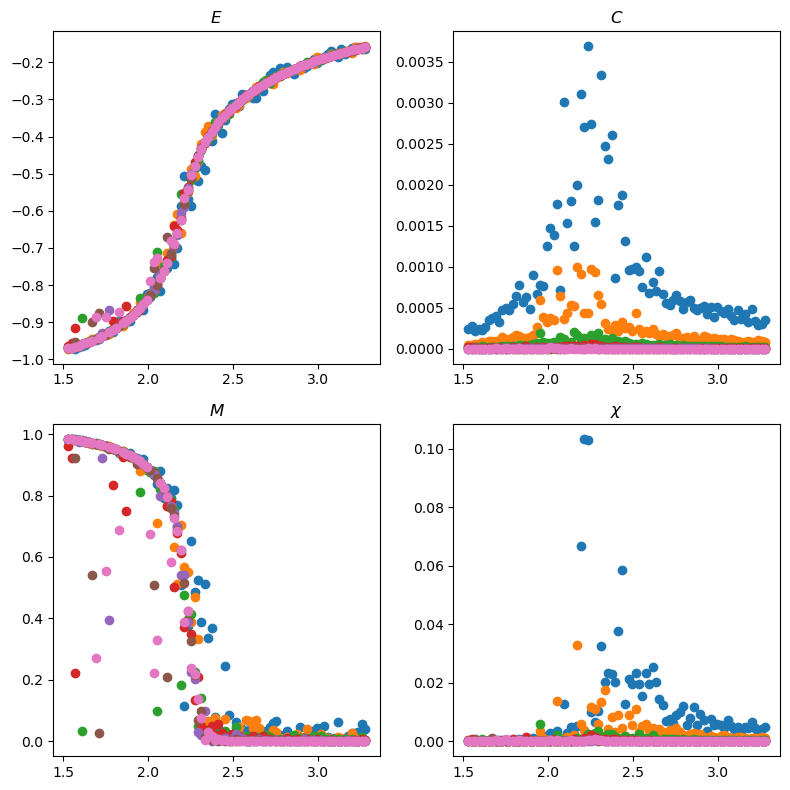

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i_s, size in enumerate(sizes):
    E = [obv[0] for obv in all_obvs[i_s]]
    M = [obv[1] for obv in all_obvs[i_s]]
    C = [obv[2] for obv in all_obvs[i_s]]
    X = [obv[3] for obv in all_obvs[i_s]]

    marker = 'o'
    axes[0, 0].plot(temps, E, marker)
    axes[1, 0].plot(temps, np.abs(M), marker)
    axes[0, 1].plot(temps, C, marker)
    axes[1, 1].plot(temps, X, marker)


    axes[0, 0].set_title(r'$E$')
    axes[1, 0].set_title(r'$M$')
    axes[0, 1].set_title(r'$C$')
    axes[1, 1].set_title(r'$\chi$')

    # data = [E, C, np.abs(M), X]
    # for i, ax in enumerate(axes.flatten()):
    #     ax.vlines(Tc, np.min(data[i]), np.max(data[i]), 'r', '--', alpha=0.8, label=rf'$T_c \approx {Tc:.4f}$')
    #     ax.set_xticks(list(ax.get_xticks())[1:] + [Tc], minor=True, labels=list(ax.get_xticklabels())[1:] + [r'$T_c$'])
    # axes[0, 0].legend()


    plt.tight_layout()
    # plt.savefig('ising_stats.png', bbox_inches='tight')